# Dự đoán giá bán căn hộ/ chung cư tại Thành phố Hồ Chí Minh
***
**Thành viên:**
- Hứa Thị Yến Lệ            : 20TCLC_DT3                                                               
- Võ Yến Nhi                : 20TCLC_DT3
- Phan Thị Thanh Tú         : 20TCLC_DT3

# <div style="text-align: left; background-color:#45C7EF; font-family:Arial; color:white; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 30px;border-style: solid;border-color: black;">MÔ HÌNH HÓA TRÊN TẬP SMALLDS</div>

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import (
    MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler,
    Normalizer, QuantileTransformer, PowerTransformer
)
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tabulate import tabulate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
sns.set_theme()

##### Tiến hành đọc file `clean_SmallDS.csv` (file đã được tiền xử lý) vào dataframe `clean_SmallDS.csv` 

In [74]:
SmallDS_df = pd.read_csv('./clean_data/clean_SmallDS.csv')

##### Loại những thuộc tính không có ý nghĩa cho việc mô hình hóa

 **Nhận xét**

- Như đã quan sát ở mục `clean_data`: Cột `DiaChi` và `DuAn` chứa các giá trị quá riêng biệt, không có ý nghĩa cho việc trực quan hay phân tích do đó các cột này sẽ không được lựa chọn làm thuộc tính đầu vào.
- Cột 'SoTang' thể hiện tầng mà căn hộ tọa lạc trong chung cư, cũng không được lấy do không có nhiều ý nghĩa.
- Do cột `Gia/m2` thật ra được tính bằng cách `GiaBan`/`DienTich` nên cũng không có giái trị cho bài toán.
- Hầu như cột `DacDiem` của bộ dữ liệu là nan hoặc 'căn góc' do đó cũng có thể loại bỏ thuộc tính này.
- Các cột của bộ dữ liệu được giữ lại bao gồm: `GiaBan`, `DienTich`, `TinhTrangBDS`, `PhongNgu`, `PhongVeSinh`, `TinhTrangGiayTo`, `TinhTrangNoiThat`, `HuongCua`, `HuongBanCong`, `Quan`
- Đây là bước loại những thuộc tính có thể thấy ngay về mặt ý nghĩa, sau khi hoàn thành các bước tiền xử lý tiếp theo sẽ thực hiện tính correlation (hệ số tương quan) giữa từng thuộc tính với biến đầu ra để có thể đưa ra những lựa chọn chính xác hơn nữa.

In [75]:
SmallDS_new_df = SmallDS_df[['Quan','DienTich(m2)', 'GiaBan', 'PhongNgu', 'PhongVeSinh', 'TinhTrangBDS', 'TinhTrangGiayTo',
                 'TinhTrangNoiThat', 'HuongBanCong', 'HuongCua']]
SmallDS_new_df.head(10)

,Quan,DienTich(m2),GiaBan,PhongNgu,PhongVeSinh,TinhTrangBDS,TinhTrangGiayTo,TinhTrangNoiThat,HuongBanCong,HuongCua
0,Thành phố Thủ Đức,58.00,1.700000,2.0,NaN,Đã bàn giao,NaN,Nội thất đầy đủ,NaN,NaN
1,Quận 7,162.75,8.000000,4.0,3.0,Chưa bàn giao,NaN,NaN,NaN,Tây
2,Thành phố Thủ Đức,56.00,1.670000,2.0,1.0,Đã bàn giao,Đã có sổ,NaN,NaN,NaN
3,Quận 7,66.60,2.500000,2.0,2.0,Đã bàn giao,NaN,NaN,NaN,Bắc
4,Quận 7,162.00,6.500000,3.0,3.0,Đã bàn giao,NaN,NaN,Đông,Tây
5,Quận Bình Thạnh,80.00,2.550000,3.0,NaN,Chưa bàn giao,Đã có sổ,NaN,NaN,NaN
6,Thành phố Thủ Đức,110.80,3.986515,3.0,NaN,Chưa bàn giao,NaN,NaN,Tây,NaN
7,Quận 12,45.00,1.580000,1.0,1.0,Chưa bàn giao,Đã có sổ,Nội thất đầy đủ,NaN,NaN
8,Quận 12,57.00,0.500000,2.0,1.0,Chưa bàn giao,NaN,NaN,NaN,Nam
9,Huyện Bình Chánh,85.00,3.400000,3.0,2.0,Đã bàn giao,NaN,NaN,Đông Nam,NaN


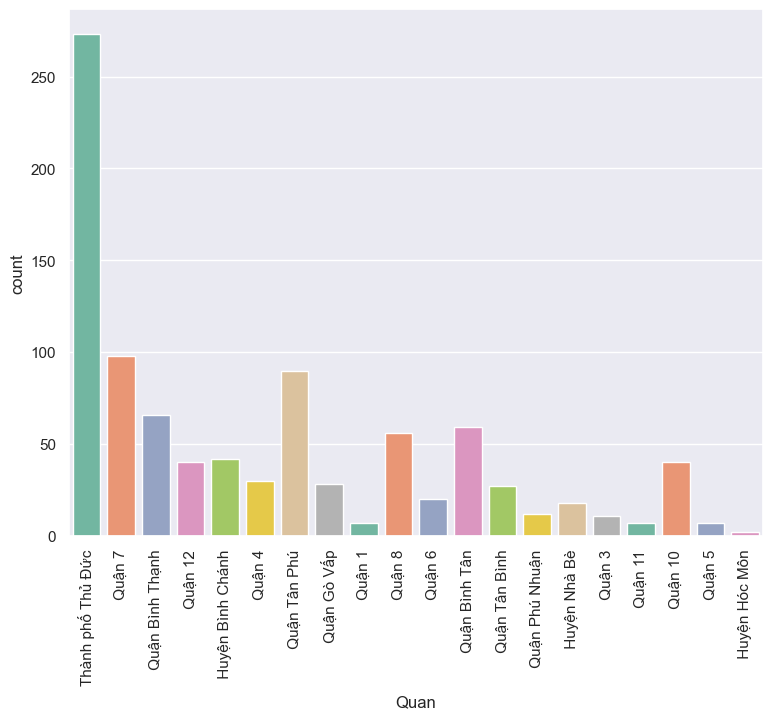

In [76]:
plt.figure(figsize=(15, 20))
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x=SmallDS_new_df['Quan'], palette="Set2")
ax1.set_xticklabels(SmallDS_new_df['Quan'].unique(), rotation=90)
plt.tight_layout()
plt.show()

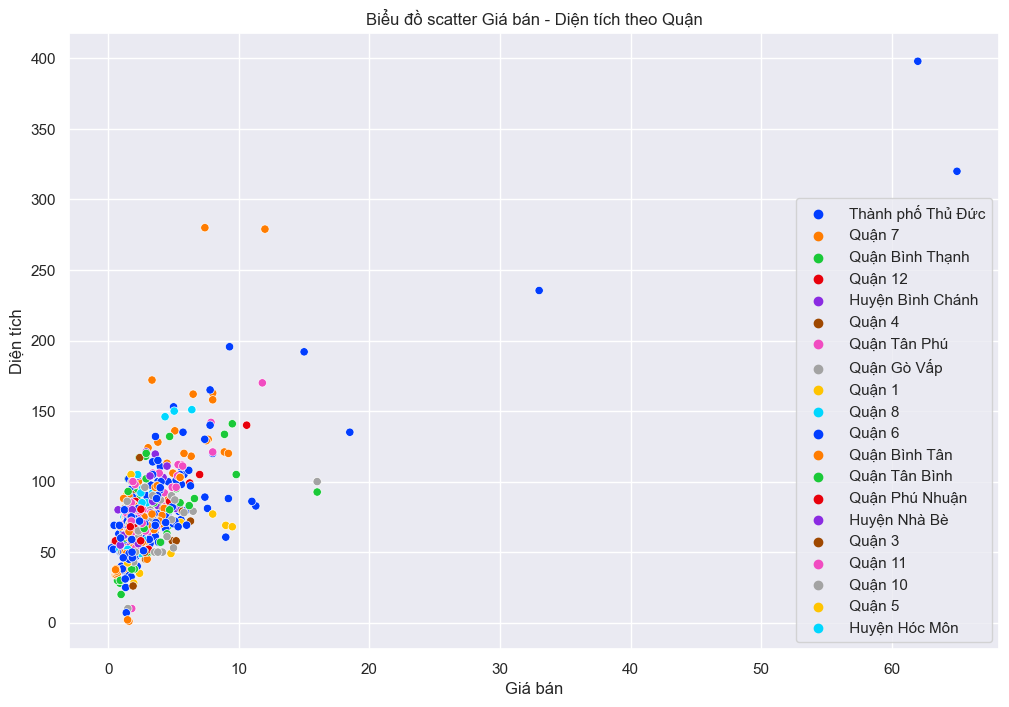

In [77]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='GiaBan', y='DienTich(m2)', hue='Quan', data=SmallDS_new_df, palette='bright')
plt.xlabel('Giá bán')
plt.ylabel('Diện tích')
plt.title('Biểu đồ scatter Giá bán - Diện tích theo Quận')
plt.legend()
plt.grid(True)
plt.show()

##### Thống kê lại thông tin của các cột đã chọn

In [78]:
SmallDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              933 non-null    object 
 1   DienTich(m2)      933 non-null    float64
 2   GiaBan            933 non-null    float64
 3   PhongNgu          933 non-null    float64
 4   PhongVeSinh       806 non-null    float64
 5   TinhTrangBDS      933 non-null    object 
 6   TinhTrangGiayTo   282 non-null    object 
 7   TinhTrangNoiThat  201 non-null    object 
 8   HuongBanCong      123 non-null    object 
 9   HuongCua          191 non-null    object 
dtypes: float64(4), object(6)
memory usage: 73.0+ KB


**Nhận xét** : Chỉ có các cột DienTich(m2), GiaBan, PhongNgu,PhongVeSinh là có kiểu 
Float64. Vì vậy ta phải Chuyển các cột `TinhTrangBDS`, `TinhTrangGiayTo`, `TinhTrangNoiThat`, `HuongBanCong`, `HuongCua`, `Quan` về dạng số để làm đầu vào cho mô hình học máy         

In [79]:
SmallDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [80]:
SmallDS_new_df["TinhTrangBDS"].unique()

array(['Đã bàn giao', 'Chưa bàn giao'], dtype=object)

In [81]:
SmallDS_new_df["TinhTrangGiayTo"].unique()

array([nan, 'Đã có sổ', 'Giấy tờ khác', 'Đang chờ sổ'], dtype=object)

In [82]:
SmallDS_new_df["Quan"].unique()

array([' Thành phố Thủ Đức', ' Quận 7', ' Quận Bình Thạnh', ' Quận 12',
       ' Huyện Bình Chánh', ' Quận 4', ' Quận Tân Phú', ' Quận Gò Vấp',
       ' Quận 1', ' Quận 8', ' Quận 6', ' Quận Bình Tân',
       ' Quận Tân Bình', ' Quận Phú Nhuận', ' Huyện Nhà Bè', ' Quận 3',
       ' Quận 11', ' Quận 10', ' Quận 5', ' Huyện Hóc Môn'], dtype=object)

In [83]:
SmallDS_new_df["TinhTrangNoiThat"].unique()

array(['Nội thất đầy đủ', nan, 'Nhà trống', 'Bàn giao thô',
       'Nội thất cao cấp'], dtype=object)

In [84]:
SmallDS_new_df["HuongBanCong"].unique()

array([nan, 'Đông', 'Tây', 'Đông Nam', 'Đông Bắc', 'Nam', 'Tây Bắc',
       'Bắc', 'Tây Nam'], dtype=object)

In [85]:
SmallDS_new_df["HuongCua"].unique()

array([nan, 'Tây', 'Bắc', 'Nam', 'Tây Bắc', 'Đông', 'Đông Nam', 'Tây Nam',
       'Đông Bắc'], dtype=object)

- Chuyển đổi dữ liệu sang dạng số và xử lý dữ liệu trống


In [86]:
def Convert_TinhTrangBDS(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangBDS'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['TinhTrangBDS'] = SmallDS_new_df['TinhTrangBDS'].astype(float)
    return SmallDS_new_df 

- Xử lý cột 'PhongVeSinh'


In [87]:
def Impute_missing_PhongVeSinh(SmallDS_new_df, impute_method, SmallDS_train=None):
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['PhongVeSinh'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['PhongVeSinh'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['PhongVeSinh'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['PhongVeSinh'].mean() if impute_method == 'mean' else \
                    SmallDS_train['PhongVeSinh'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['PhongVeSinh'].median() if impute_method == 'median' else None
    SmallDS_new_df['PhongVeSinh'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lý cột 'TinhTrangGiayTo'


In [88]:
def Convert_TinhTrangGiayTo(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangGiayTo'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['TinhTrangGiayTo'] = SmallDS_new_df['TinhTrangGiayTo'].astype(float)
    return SmallDS_new_df
def Impute_missing_TinhTrangGiayTo(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_TinhTrangGiayTo(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['TinhTrangGiayTo'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['TinhTrangGiayTo'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['TinhTrangGiayTo'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['TinhTrangGiayTo'].mean() if impute_method == 'mean' else \
                    SmallDS_train['TinhTrangGiayTo'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['TinhTrangGiayTo'].median() if impute_method == 'median' else None
    SmallDS_new_df['TinhTrangGiayTo'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lý cột 'TinhTrangNoiThat'


In [89]:
def Convert_TinhTrangNoiThat(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['TinhTrangNoiThat'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['TinhTrangNoiThat'] = SmallDS_new_df['TinhTrangNoiThat'].astype(float)
    return SmallDS_new_df
def Impute_missing_TinhTrangNoiThat(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_TinhTrangNoiThat(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['TinhTrangNoiThat'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['TinhTrangNoiThat'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['TinhTrangNoiThat'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['TinhTrangNoiThat'].mean() if impute_method == 'mean' else \
                    SmallDS_train['TinhTrangNoiThat'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['TinhTrangNoiThat'].median() if impute_method == 'median' else None
    SmallDS_new_df['TinhTrangNoiThat'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lí cột 'HuongBanCong'


In [90]:
def Convert_HuongBanCong(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongBanCong'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['HuongBanCong'] = SmallDS_new_df['HuongBanCong'].astype(float)
    return SmallDS_new_df
def Impute_missing_HuongBanCong(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_HuongBanCong(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['HuongBanCong'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['HuongBanCong'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['HuongBanCong'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['HuongBanCong'].mean() if impute_method == 'mean' else \
                    SmallDS_train['HuongBanCong'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['HuongBanCong'].median() if impute_method == 'median' else None
    SmallDS_new_df['HuongBanCong'].fillna(fill_value, inplace=True)
    return SmallDS_new_df


- Xử lí trên cột 'HuongCua'


In [91]:
def Convert_HuongCua(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['HuongCua'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['HuongCua'] = SmallDS_new_df['HuongCua'].astype(float)
    return SmallDS_new_df
def Impute_missing_HuongCua(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_HuongCua(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['HuongCua'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['HuongCua'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['HuongCua'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['HuongCua'].mean() if impute_method == 'mean' else \
                    SmallDS_train['HuongCua'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['HuongCua'].median() if impute_method == 'median' else None
    SmallDS_new_df['HuongCua'].fillna(fill_value, inplace=True)
    return SmallDS_new_df

- Xử lí dữ liệu trên cột 'Quan'


In [92]:
def Convert_Quan(SmallDS_new_df):
    encoder = ce.OrdinalEncoder(cols=['Quan'])
    SmallDS_new_df = encoder.fit_transform(SmallDS_new_df)
    SmallDS_new_df['Quan'] = SmallDS_new_df['Quan'].astype(float)
    return SmallDS_new_df
def Impute_missing_Quan(SmallDS_new_df, impute_method, SmallDS_train=None):
    SmallDS_new_df = Convert_Quan(SmallDS_new_df)
    if SmallDS_train is None:
        fill_value = SmallDS_new_df['Quan'].mean() if impute_method == 'mean' else \
                    SmallDS_new_df['Quan'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_new_df['Quan'].median() if impute_method == 'median' else None
    else:
        fill_value = SmallDS_train['Quan'].mean() if impute_method == 'mean' else \
                    SmallDS_train['Quan'].mode()[0] if impute_method == 'mode' else \
                    SmallDS_train['Quan'].median() if impute_method == 'median' else None
    SmallDS_new_df['Quan'].fillna(fill_value, inplace=True)
    return SmallDS_new_df


In [93]:
SmallDS_new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              933 non-null    object 
 1   DienTich(m2)      933 non-null    float64
 2   GiaBan            933 non-null    float64
 3   PhongNgu          933 non-null    float64
 4   PhongVeSinh       806 non-null    float64
 5   TinhTrangBDS      933 non-null    object 
 6   TinhTrangGiayTo   282 non-null    object 
 7   TinhTrangNoiThat  201 non-null    object 
 8   HuongBanCong      123 non-null    object 
 9   HuongCua          191 non-null    object 
dtypes: float64(4), object(6)
memory usage: 73.0+ KB


# Chia train, test, val

In [94]:
X_SmallDS = SmallDS_new_df.drop(columns=['GiaBan'])
y_SmallDS = np.log(SmallDS_new_df['GiaBan'])
X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X_SmallDS,y_SmallDS,test_size=0.4,random_state=20)
X_test_s, X_val_s, y_test_s, y_val_s = train_test_split(X_test_s, y_test_s, test_size=0.5, random_state=20)

# Xử lí dữ liệu trống

In [95]:
X_train_s = Impute_missing_PhongVeSinh(X_train_s,'median')
X_test_s = Impute_missing_PhongVeSinh(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_PhongVeSinh(X_val_s,'median',X_train_s)
# Xử lí trên cột 'TinhTrangGiayTo'
X_train_s = Impute_missing_TinhTrangGiayTo(X_train_s,'median')
X_test_s = Impute_missing_TinhTrangGiayTo(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_TinhTrangGiayTo(X_val_s,'median',X_train_s)
# - Xử lí trên cột 'TinhTrangNoiThat'
X_train_s = Impute_missing_TinhTrangNoiThat(X_train_s,'median')
X_test_s = Impute_missing_TinhTrangNoiThat(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_TinhTrangNoiThat(X_val_s,'median',X_train_s)
# Cột hướng ban công
X_train_s = Impute_missing_HuongBanCong(X_train_s,'median')
X_test_s = Impute_missing_HuongBanCong(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_HuongBanCong(X_val_s,'median',X_train_s)
# Cột hướng cửa
X_train_s = Impute_missing_HuongCua(X_train_s,'median')
X_test_s = Impute_missing_HuongCua(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_HuongCua(X_val_s,'median',X_train_s)
# Quận
X_train_s = Impute_missing_Quan(X_train_s,'median')
X_test_s = Impute_missing_Quan(X_test_s,'median',X_train_s)
X_val_s = Impute_missing_Quan(X_val_s,'median',X_train_s)
# Cột tình trạng bất động sản
X_train_s = Convert_TinhTrangBDS(X_train_s)
X_test_s = Convert_TinhTrangBDS(X_test_s)
X_val_s = Convert_TinhTrangBDS(X_val_s)

In [96]:
X_train_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 559 entries, 691 to 355
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              559 non-null    float64
 1   DienTich(m2)      559 non-null    float64
 2   PhongNgu          559 non-null    float64
 3   PhongVeSinh       559 non-null    float64
 4   TinhTrangBDS      559 non-null    float64
 5   TinhTrangGiayTo   559 non-null    float64
 6   TinhTrangNoiThat  559 non-null    float64
 7   HuongBanCong      559 non-null    float64
 8   HuongCua          559 non-null    float64
dtypes: float64(9)
memory usage: 43.7 KB


In [97]:
X_test_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 731 to 708
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              187 non-null    float64
 1   DienTich(m2)      187 non-null    float64
 2   PhongNgu          187 non-null    float64
 3   PhongVeSinh       187 non-null    float64
 4   TinhTrangBDS      187 non-null    float64
 5   TinhTrangGiayTo   187 non-null    float64
 6   TinhTrangNoiThat  187 non-null    float64
 7   HuongBanCong      187 non-null    float64
 8   HuongCua          187 non-null    float64
dtypes: float64(9)
memory usage: 14.6 KB


In [98]:
X_val_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187 entries, 195 to 414
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Quan              187 non-null    float64
 1   DienTich(m2)      187 non-null    float64
 2   PhongNgu          187 non-null    float64
 3   PhongVeSinh       187 non-null    float64
 4   TinhTrangBDS      187 non-null    float64
 5   TinhTrangGiayTo   187 non-null    float64
 6   TinhTrangNoiThat  187 non-null    float64
 7   HuongBanCong      187 non-null    float64
 8   HuongCua          187 non-null    float64
dtypes: float64(9)
memory usage: 14.6 KB


#### Biểu đồ histogram

In [99]:
train_data = X_train_s.join(y_train_s)

array([[<AxesSubplot:title={'center':'Quan'}>,
        <AxesSubplot:title={'center':'DienTich(m2)'}>,
        <AxesSubplot:title={'center':'PhongNgu'}>],
       [<AxesSubplot:title={'center':'PhongVeSinh'}>,
        <AxesSubplot:title={'center':'TinhTrangBDS'}>,
        <AxesSubplot:title={'center':'TinhTrangGiayTo'}>],
       [<AxesSubplot:title={'center':'TinhTrangNoiThat'}>,
        <AxesSubplot:title={'center':'HuongBanCong'}>,
        <AxesSubplot:title={'center':'HuongCua'}>]], dtype=object)

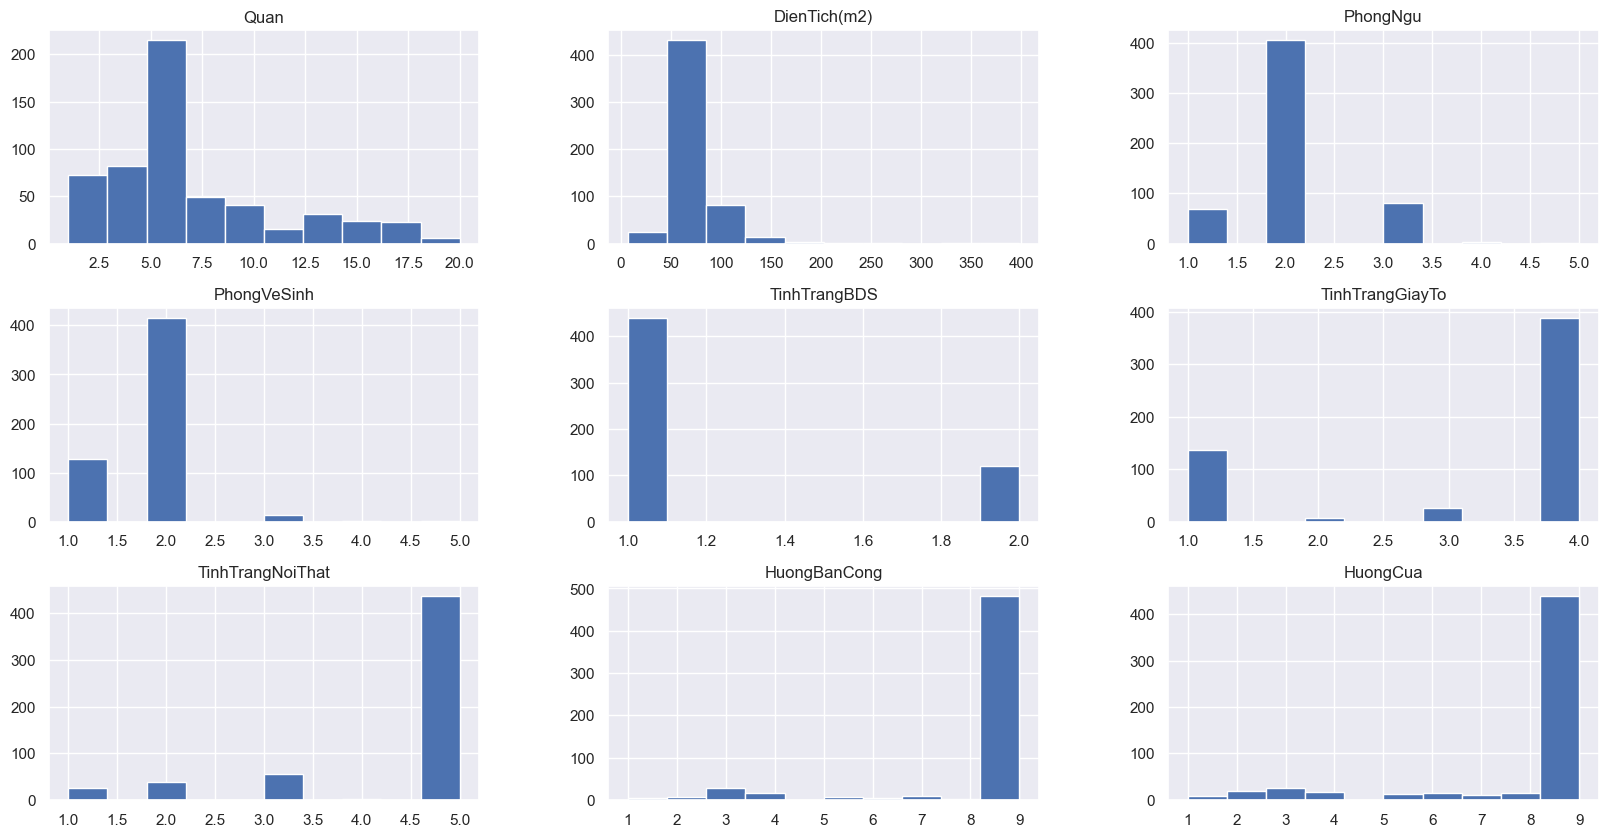

In [100]:
X_train_s.hist(figsize=(20,10))

#### Tính Correlations và tiếp tục chọn những thuộc tính thật sự có giá tr

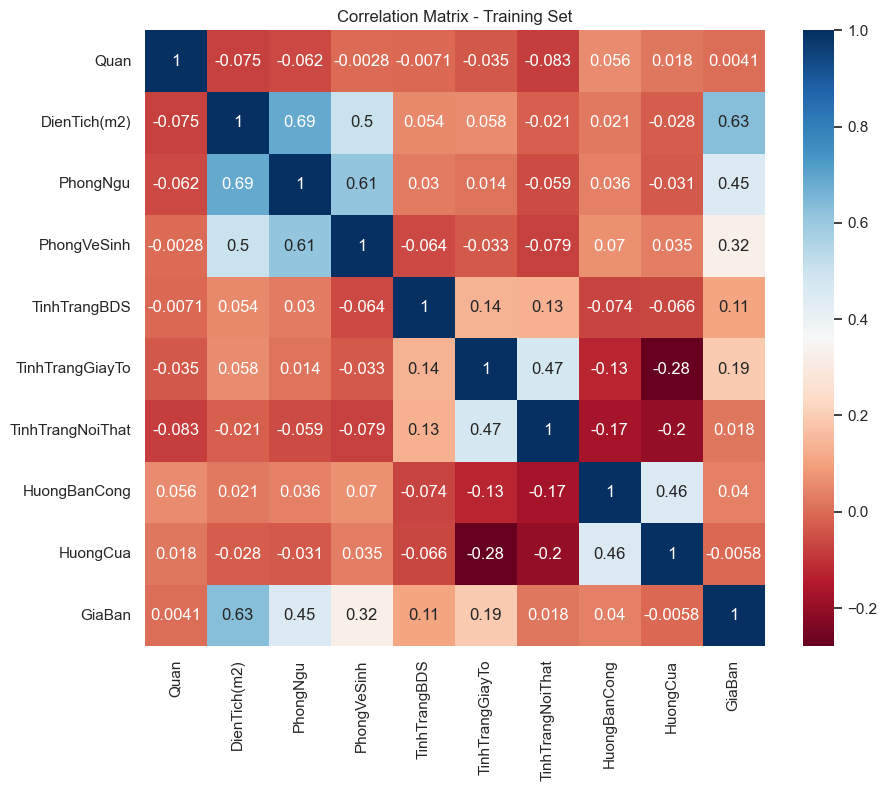

In [101]:
correlation_matrix = X_train_s.copy()
correlation_matrix['GiaBan'] = y_train_s
correlation_matrix = correlation_matrix.corr()
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu')  
plt.title('Correlation Matrix - Training Set')
plt.show()  


- Correlation cao nhất có giá trị là 1 (hai biến hoàn toàn có quan hệ tuyến tính) và thấp nhất dần nếu hai biến càng không có quan hệ tuyến tính.
- Nhóm sẽ tạo một dataframe tên là 'correlations' chứa các correlations của từng cột trong bộ dữ liệu để dễ dàng nhận xét mức độ tương quan giữa các biến.

##### Tiếp tục sử dụng SelectKBest để lauwj chọn 5 thuộc tính tốt nhất

In [102]:
k_best = SelectKBest(f_regression, k=5)
X_train_selected = k_best.fit_transform(X_train_s, y_train_s)
selected_features = X_train_s.columns[k_best.get_support()]
X_val_selected = k_best.transform(X_val_s)
X_test_selected = k_best.transform(X_test_s)
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['DienTich(m2)', 'PhongNgu', 'PhongVeSinh', 'TinhTrangBDS',
       'TinhTrangGiayTo'],
      dtype='object')


- Các thuộc tính 'Quan' và 'TinhTrangNoiThat', 'HuongCua', 'HuongBanCong'  có correlation cũng thấp, chứng tỏ không ảnh hưởng đến 'GiaBan'.
- Các thuộc tính được giữ lại: 'DienTich', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS',',TinhTrangGiayTo' Và cột biến đầu ra 'GiaBan'.

##### Lựa chọn đặc trưng

In [103]:
X_train_s = X_train_s[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_val_s = X_val_s[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]
X_test_s = X_test_s[['DienTich(m2)', 'PhongNgu', 'PhongVeSinh','TinhTrangBDS','TinhTrangGiayTo']]

### Xem tác động các tính năng đến giá bán

#### Xử lí ngoại lệ cột PhongNgu

In [104]:
norm_upper_limit_train = X_train_s['PhongNgu'].mean() + 3 * X_train_s['PhongNgu'].std()
norm_lower_limit_train = X_train_s['PhongNgu'].mean() - 3 * X_train_s['PhongNgu'].std()
norm_upper_limit_test = X_test_s['PhongNgu'].mean() + 3 * X_test_s['PhongNgu'].std()
norm_lower_limit_test = X_test_s['PhongNgu'].mean() - 3 * X_test_s['PhongNgu'].std()
norm_upper_limit_val = X_val_s['PhongNgu'].mean() + 3 * X_val_s['PhongNgu'].std()
norm_lower_limit_val = X_val_s['PhongNgu'].mean() - 3 * X_val_s['PhongNgu'].std()
df_normal_new_train = X_train_s[(X_train_s['PhongNgu'] > norm_lower_limit_train) & ( X_train_s['PhongNgu'] < norm_upper_limit_train)]
df_normal_new_test = X_test_s[(X_test_s['PhongNgu'] > norm_lower_limit_test) & ( X_test_s['PhongNgu'] < norm_upper_limit_test)]
df_normal_new_val = X_val_s[(X_val_s['PhongNgu'] > norm_lower_limit_val) & ( X_val_s['PhongNgu'] < norm_upper_limit_val)]

In [105]:
print("Before Triming Size:", X_train_s.shape[0])
print("After Triming Size:", df_normal_new_train.shape[0])

Before Triming Size: 559
After Triming Size: 554


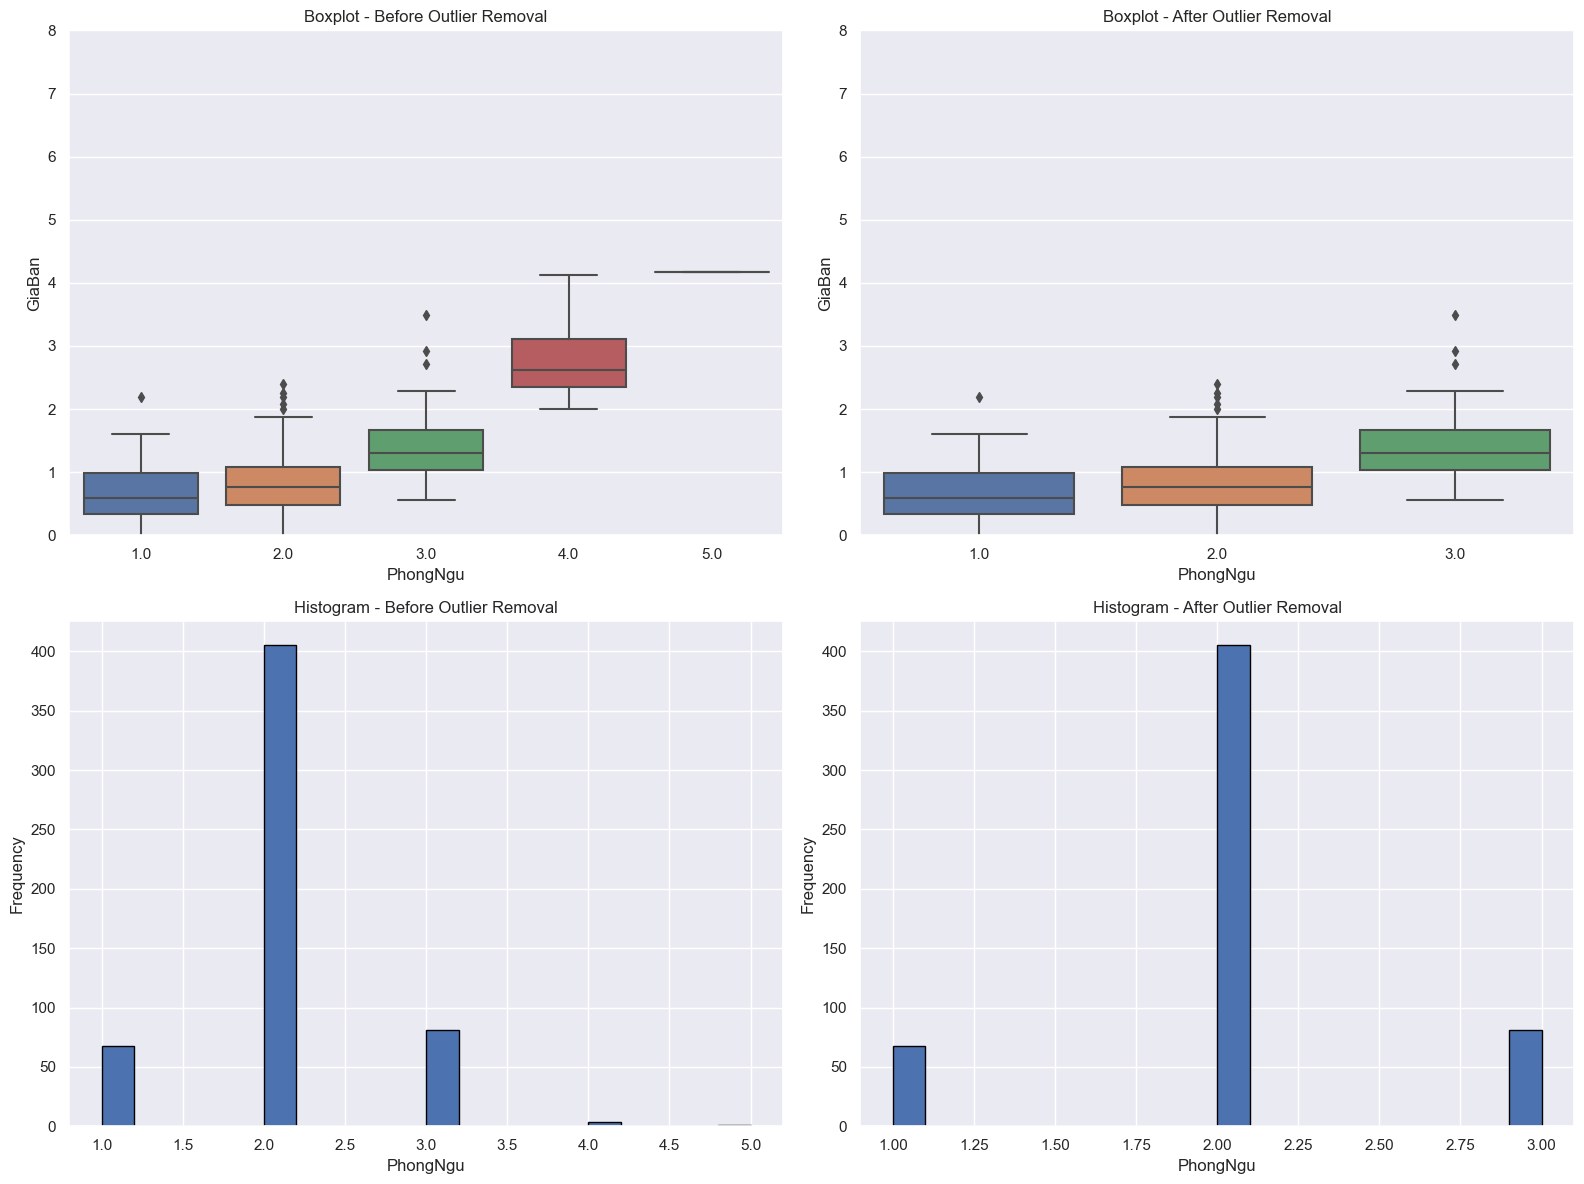

In [106]:
var = 'PhongNgu'
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot - Before Outlier Removal
data_before_outlier = pd.concat([y_train_s, X_train_s[var]], axis=1)
sns.boxplot(x=var, y=y_train_s, data=data_before_outlier, ax=axes[0, 0])
axes[0, 0].set_ylim(0, 8)
axes[0, 0].set_xlabel(var)
axes[0, 0].set_ylabel('GiaBan')
axes[0, 0].set_title('Boxplot - Before Outlier Removal')

# Boxplot - After Outlier Removal
data_outlier_removal = pd.concat([y_train_s, df_normal_new_train[var]], axis=1)
sns.boxplot(x=var, y='GiaBan', data=data_outlier_removal, ax=axes[0, 1])
axes[0, 1].set_ylim(0, 8)
axes[0, 1].set_xlabel(var)
axes[0, 1].set_ylabel('GiaBan')
axes[0, 1].set_title('Boxplot - After Outlier Removal')

# Histogram - Before Outlier Removal
axes[1, 0].hist(X_train_s[var], bins=20, edgecolor='black')
axes[1, 0].set_xlabel(var)
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram - Before Outlier Removal')

# Histogram - After Outlier Removal
axes[1, 1].hist(df_normal_new_train[var], bins=20, edgecolor='black')
axes[1, 1].set_xlabel(var)
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram - After Outlier Removal')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


#### Xử lí ngoại lệ cột PhongVeSinh

In [107]:
norm_upper_limit_train = X_train_s['PhongVeSinh'].mean() + 3 * X_train_s['PhongVeSinh'].std()
norm_lower_limit_train = X_train_s['PhongVeSinh'].mean() - 3 * X_train_s['PhongVeSinh'].std()
norm_upper_limit_test = X_test_s['PhongVeSinh'].mean() + 3 * X_test_s['PhongVeSinh'].std()
norm_lower_limit_test = X_test_s['PhongVeSinh'].mean() - 3 * X_test_s['PhongVeSinh'].std()
norm_upper_limit_val = X_val_s['PhongVeSinh'].mean() + 3 * X_val_s['PhongVeSinh'].std()
norm_lower_limit_val = X_val_s['PhongVeSinh'].mean() - 3 * X_val_s['PhongVeSinh'].std()

df_normal_new_train = X_train_s[(X_train_s['PhongVeSinh'] > norm_lower_limit_train) & ( X_train_s['PhongVeSinh'] < norm_upper_limit_train)]
df_normal_new_test = X_test_s[(X_test_s['PhongVeSinh'] > norm_lower_limit_test) & ( X_test_s['PhongVeSinh'] < norm_upper_limit_test)]
df_normal_new_val = X_val_s[(X_val_s['PhongVeSinh'] > norm_lower_limit_val) & ( X_val_s['PhongVeSinh'] < norm_upper_limit_val)]

In [108]:
print("Before Triming Size:", X_train_s.shape[0])
print("After Triming Size:", df_normal_new_train.shape[0])

Before Triming Size: 559
After Triming Size: 556


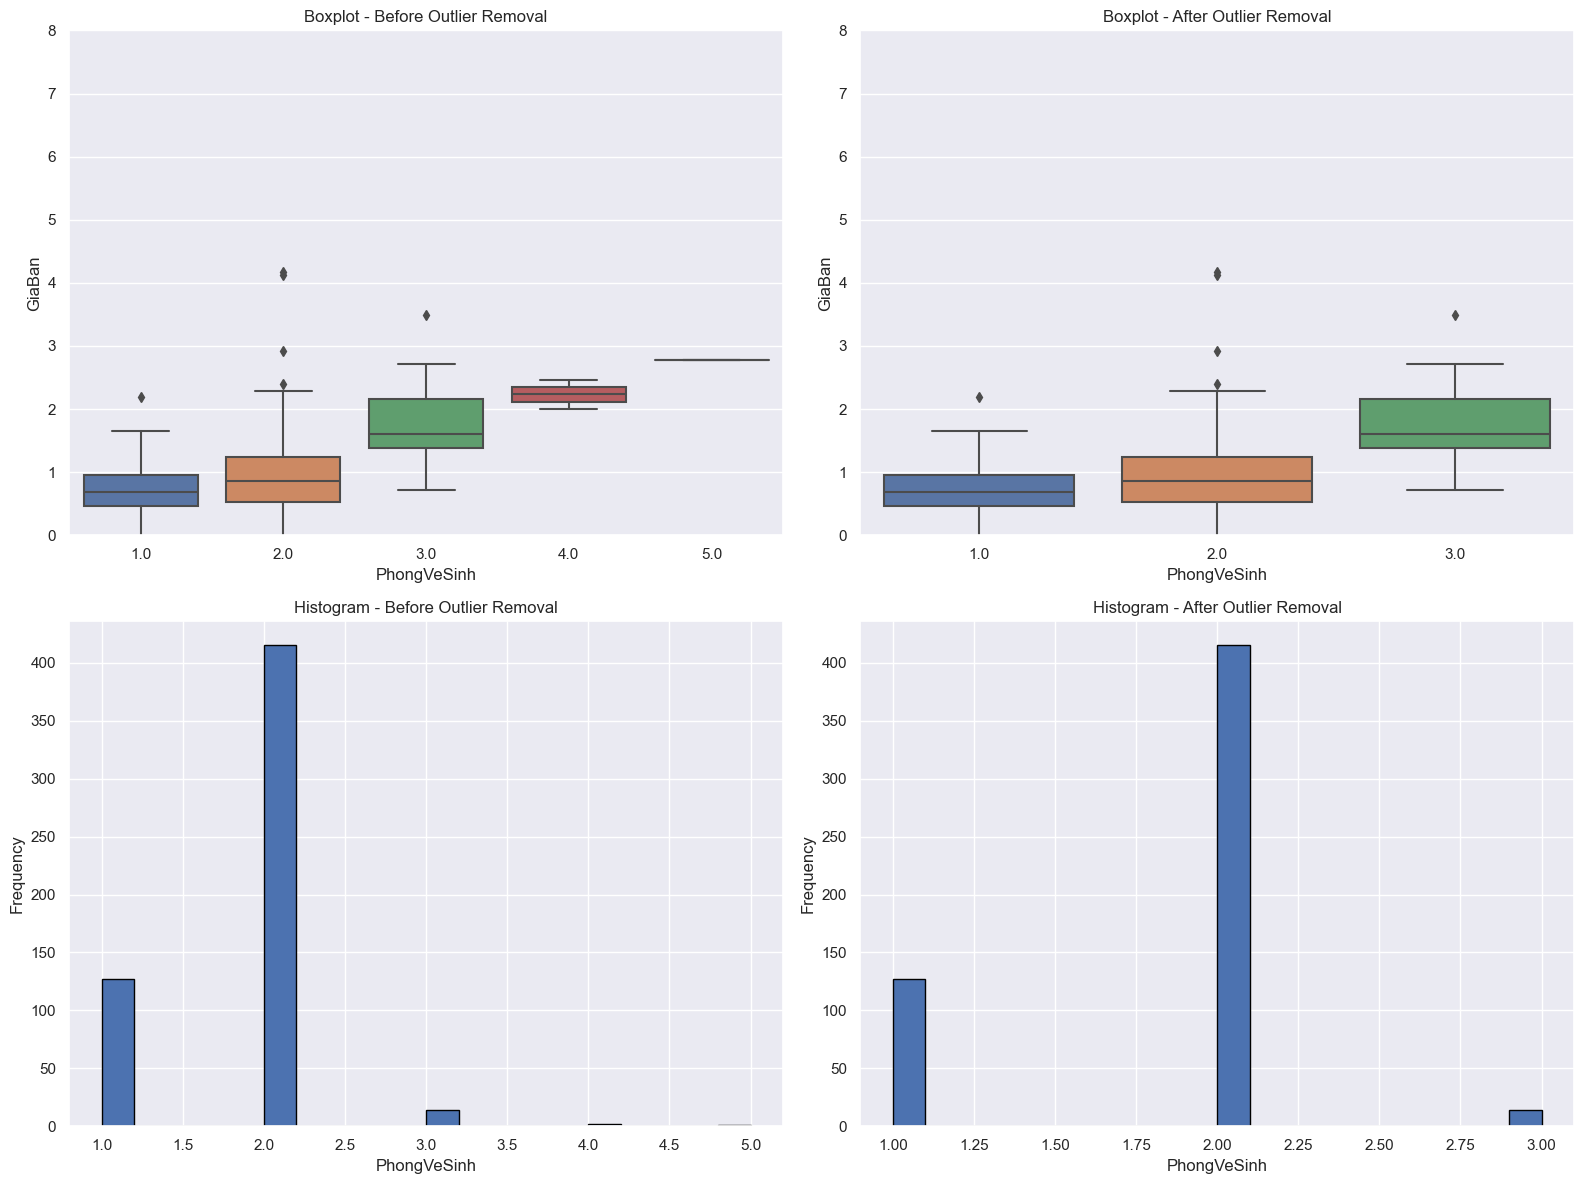

In [109]:
var = 'PhongVeSinh'
# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot - Before Outlier Removal
data_before_outlier = pd.concat([y_train_s, X_train_s[var]], axis=1)
sns.boxplot(x=var, y=y_train_s, data=data_before_outlier, ax=axes[0, 0])
axes[0, 0].set_ylim(0, 8)
axes[0, 0].set_xlabel(var)
axes[0, 0].set_ylabel('GiaBan')
axes[0, 0].set_title('Boxplot - Before Outlier Removal')

# Boxplot - After Outlier Removal
data_outlier_removal = pd.concat([y_train_s, df_normal_new_train[var]], axis=1)
sns.boxplot(x=var, y='GiaBan', data=data_outlier_removal, ax=axes[0, 1])
axes[0, 1].set_ylim(0, 8)
axes[0, 1].set_xlabel(var)
axes[0, 1].set_ylabel('GiaBan')
axes[0, 1].set_title('Boxplot - After Outlier Removal')

# Histogram - Before Outlier Removal
axes[1, 0].hist(X_train_s[var], bins=20, edgecolor='black')
axes[1, 0].set_xlabel(var)
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Histogram - Before Outlier Removal')

# Histogram - After Outlier Removal
axes[1, 1].hist(df_normal_new_train[var], bins=20, edgecolor='black')
axes[1, 1].set_xlabel(var)
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram - After Outlier Removal')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


#### Không xử lí cột TinhTrangBDS

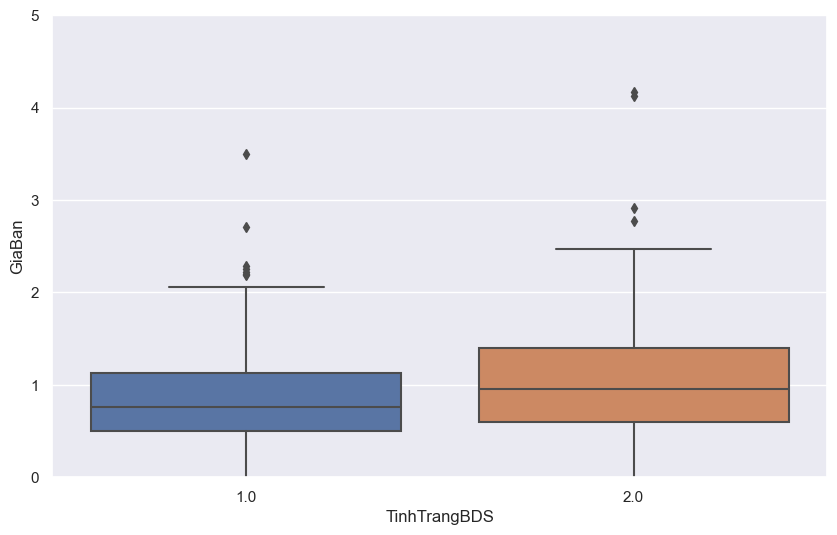

In [110]:
var = 'TinhTrangBDS'
data = pd.concat([y_train_s, X_train_s['TinhTrangBDS']], axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x=var, y=y_train_s, data=data)
plt.ylim(0, 5) 
plt.show()

#### Không xử lí cột TinhTrangGiayTo

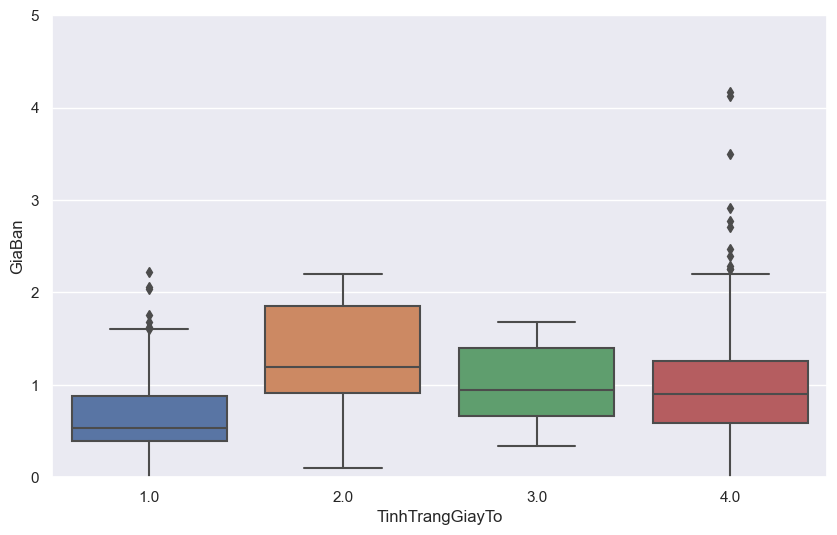

In [111]:
var = 'TinhTrangGiayTo'
data = pd.concat([y_train_s, X_train_s['TinhTrangGiayTo']], axis=1)
plt.figure(figsize=(10, 6))
sns.boxplot(x=var, y=y_train_s, data=data)
plt.ylim(0, 5) 
plt.show()

* Các thuộc tính này ít ngoại lệ nên chúng ta không cần xử lí ngoại lệ cho các cột này, ta chỉ cần xử lí cột DienTich(m2)

### Xử lý ngoại lệ cột 'DienTich(m2)

In [112]:
norm_upper_limit_train = X_train_s['DienTich(m2)'].mean() + 3 * X_train_s['DienTich(m2)'].std()
norm_lower_limit_train = X_train_s['DienTich(m2)'].mean() - 3 * X_train_s['DienTich(m2)'].std()
norm_upper_limit_test = X_test_s['DienTich(m2)'].mean() + 3 * X_test_s['DienTich(m2)'].std()
norm_lower_limit_test = X_test_s['DienTich(m2)'].mean() - 3 * X_test_s['DienTich(m2)'].std()
norm_upper_limit_val = X_val_s['DienTich(m2)'].mean() + 3 * X_val_s['DienTich(m2)'].std()
norm_lower_limit_val = X_val_s['DienTich(m2)'].mean() - 3 * X_val_s['DienTich(m2)'].std()

df_normal_new_train = X_train_s[(X_train_s['DienTich(m2)'] > norm_lower_limit_train) & ( X_train_s['DienTich(m2)'] < norm_upper_limit_train)]
df_normal_new_test = X_test_s[(X_test_s['DienTich(m2)'] > norm_lower_limit_test) & ( X_test_s['DienTich(m2)'] < norm_upper_limit_test)]
df_normal_new_val = X_val_s[(X_val_s['DienTich(m2)'] > norm_lower_limit_val) & ( X_val_s['DienTich(m2)'] < norm_upper_limit_val)]

In [113]:
df_normal_new_train = X_train_s[(X_train_s['DienTich(m2)'] > norm_lower_limit_train) & ( X_train_s['DienTich(m2)'] < norm_upper_limit_train)]
df_normal_new_test = X_test_s[(X_test_s['DienTich(m2)'] > norm_lower_limit_test) & ( X_test_s['DienTich(m2)'] < norm_upper_limit_test)]
df_normal_new_val = X_val_s[(X_val_s['DienTich(m2)'] > norm_lower_limit_val) & ( X_val_s['DienTich(m2)'] < norm_upper_limit_val)]

In [114]:
print("Before Outlier Size:", X_train_s.shape[0])
print("After Outlier Size:", df_normal_new_train.shape[0])

Before Outlier Size: 559
After Outlier Size: 552


<AxesSubplot:>

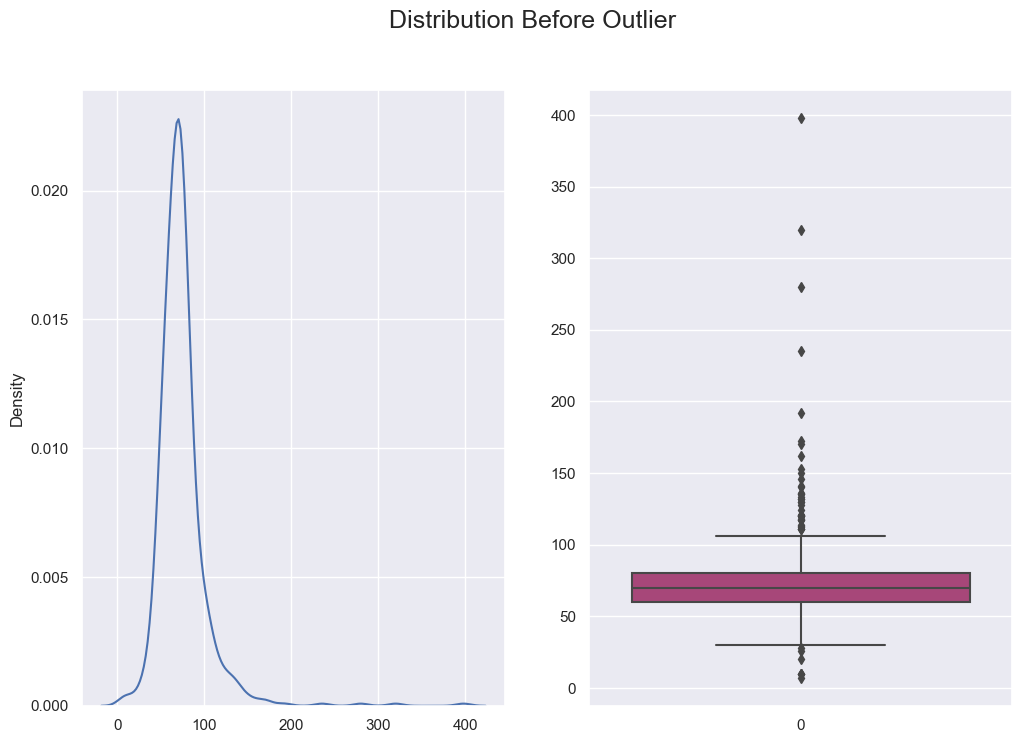

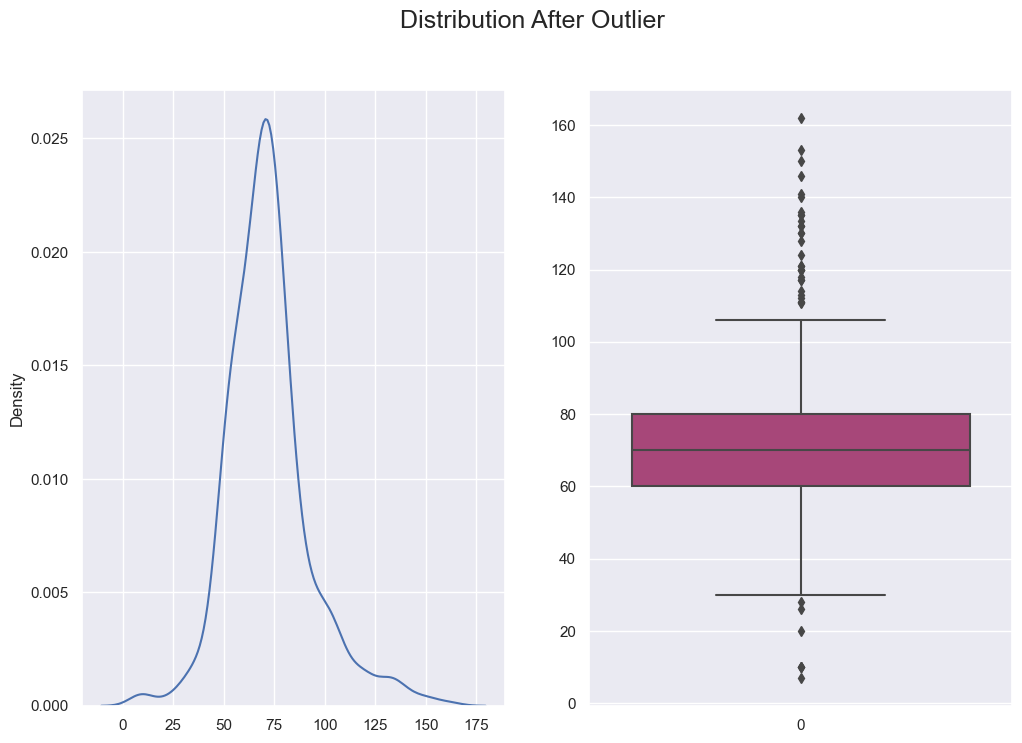

In [115]:
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution Before Outlier", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = X_train_s['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = X_train_s['DienTich(m2)'].values, palette = "magma")
plt.figure(figsize = (12, 8))
plt.suptitle("Distribution After Outlier", fontsize = 18)
plt.subplot(1, 2, 1)
sns.kdeplot(data = df_normal_new_train['DienTich(m2)'].values)
plt.subplot(1, 2, 2)
sns.boxplot(data = df_normal_new_train['DienTich(m2)'].values, palette = "magma")

In [116]:
def scaler_transform(X_train,X_test,X_val,scaler_type):
    if scaler_type == 'standard':
        scaler = StandardScaler()
    elif scaler_type == 'min_max':
        scaler = MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = RobustScaler()
    elif scaler_type == 'maxabs':
        scaler = MaxAbsScaler()
    elif scaler_type == 'norma':
        scaler = Normalizer()
    elif scaler_type == 'quantil':
        scaler = QuantileTransformer(n_quantiles=620)
    elif scaler_type == 'powert':
        scaler = PowerTransformer()
    else:
        raise ValueError('Scaler not recognized')
    X_train_tranformed =  pd.DataFrame(scaler.fit_transform(X_train))
    X_test_tranformed  =  pd.DataFrame(scaler.transform(X_test))
    X_val_tranformed   =  pd.DataFrame(scaler.transform(X_val))
    return X_train_tranformed,X_test_tranformed,X_val_tranformed

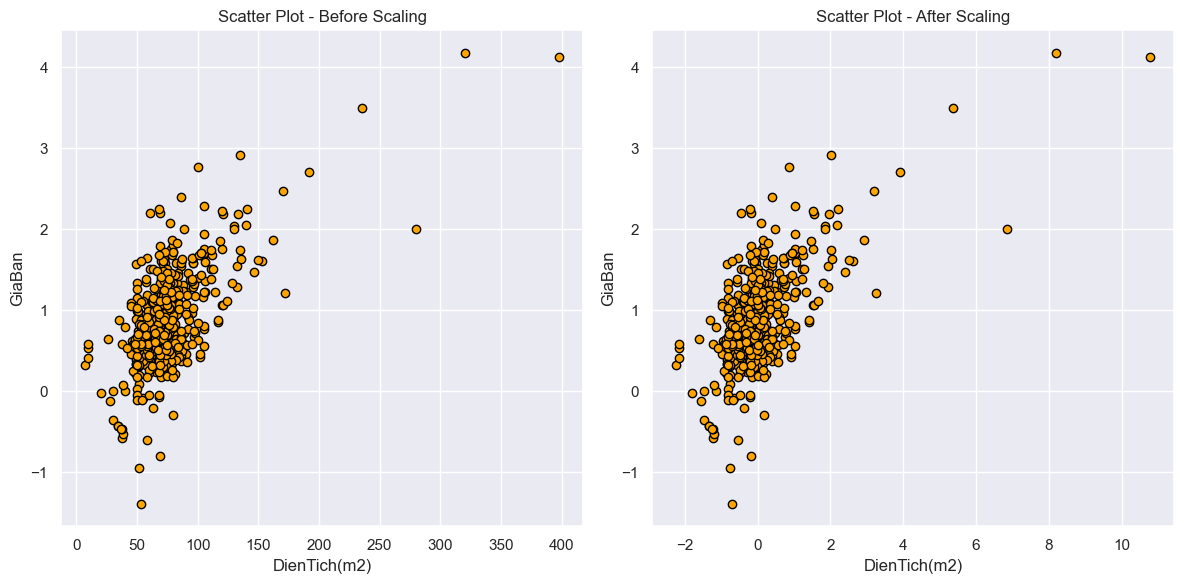

In [117]:
fig, axes = plt.subplots(1,2 ,figsize=(12, 6))
axes[0].scatter(X_train_s['DienTich(m2)'], y_train_s,facecolor='orange', edgecolor='black')
axes[0].set_xlabel('DienTich(m2)')
axes[0].set_ylabel('GiaBan')
axes[0].set_title('Scatter Plot - Before Scaling')
X_train_s, X_test_s, X_val_s = scaler_transform(X_train_s, X_test_s, X_val_s,'standard')
axes[1].scatter(X_train_s[0], y_train_s,facecolor='orange', edgecolor='black')
axes[1].set_xlabel('DienTich(m2)')
axes[1].set_ylabel('GiaBan')
axes[1].set_title('Scatter Plot - After Scaling')
plt.tight_layout()
plt.show()

MAE và MSE là hai độ đo đánh giá mức độ chính xác của mô hình dự đoán so với giá trị thực tế.

MAE (Mean Absolute Error): là trung bình cộng của giá trị tuyệt đối của sai số giữa giá trị dự đoán và giá trị thực tế. MAE càng thấp thì mô hình dự đoán càng chính xác.

MSE (Mean Squared Error): là trung bình cộng của bình phương sai số giữa giá trị dự đoán và giá trị thực tế. MSE càng thấp thì mô hình dự đoán càng chính xác.

### Sử dụng mô hình LinearRegression

In [118]:
X_train_linear=X_train_s.copy()
X_test_linear=X_test_s.copy()
X_val_linear=X_val_s.copy()
y_train_linear=y_train_s.copy()
y_test_linear=y_test_s.copy()
y_val_linear=y_val_s.copy()

##### Trước khi hiệu chỉnh

In [119]:
model = LinearRegression()
model.fit(X_train_linear, y_train_linear)
y_val_pred = model.predict(X_val_linear)
r2_val_before_linear = r2_score(y_val_linear, y_val_pred).round(4)
y_test_pred = model.predict(X_test_linear)
r2_test_before_linear = r2_score(y_test_linear, y_test_pred).round(4)
mae_val_before_linear = mean_absolute_error(y_val_linear, y_val_pred).round(4)
mae_test_before_linear = mean_absolute_error(y_test_linear, y_test_pred).round(4)
mse_val_before_linear = mean_squared_error(y_val_linear,y_val_pred).round(4)
mse_test_before_linear = mean_squared_error(y_test_linear,y_test_pred).round(4)
print("r2_score in validation:", r2_val_before_linear)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before_linear))
print("Test error (MAE) in test: {}".format(mae_test_before_linear))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before_linear))
print("Test error (MSE) in test: {}".format(mse_test_before_linear))

r2_score in validation: 0.5102

Test error (MAE) in validation: 0.2679
Test error (MAE) in test: 0.3046

Test error (MSE) in validation: 0.1266
Test error (MSE) in test: 0.1545


##### Tìm bộ tham số

In [120]:
model = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_linear, y_train_linear)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))


Best parameters: {'copy_X': True, 'fit_intercept': True}


##### Truyền tham số tốt nhất vào để chạy trên tập test

In [121]:
model = LinearRegression(fit_intercept = True, copy_X = True)
model.fit(X_train_linear, y_train_linear)
y_val_pred = model.predict(X_val_linear)
r2_val_after_linear = r2_score(y_val_linear, y_val_pred).round(5)
y_test_pred = model.predict(X_test_linear)
r2_test_after_linear = r2_score(y_test_linear, y_test_pred).round(5)
mae_test_after_linear = mean_absolute_error(y_test_linear,y_test_pred).round(5)
mae_val_after_linear = mean_absolute_error(y_val_linear,y_val_pred).round(5)
mse_test_after_linear = mean_squared_error(y_test_linear,y_test_pred).round(5)
mse_val_after_linear = mean_squared_error(y_val_linear,y_val_pred).round(5)
print("R2-score in  validation:", r2_val_after_linear)
print("R2-score in test:", r2_test_after_linear)
print()
print("Test error (MAE) in test: {}".format(mae_test_after_linear))
print("Test error (MAE) in validation: {}".format(mae_val_after_linear))
print()
print("Test error (MSE) in test: {}".format(mse_test_after_linear))
print("Test error (MSE) in validation: {}".format(mse_val_after_linear))
print()


R2-score in  validation: 0.5102
R2-score in test: 0.41892

Test error (MAE) in test: 0.3046
Test error (MAE) in validation: 0.26787

Test error (MSE) in test: 0.15447
Test error (MSE) in validation: 0.12661



##### Vẽ biểu đồ scatter

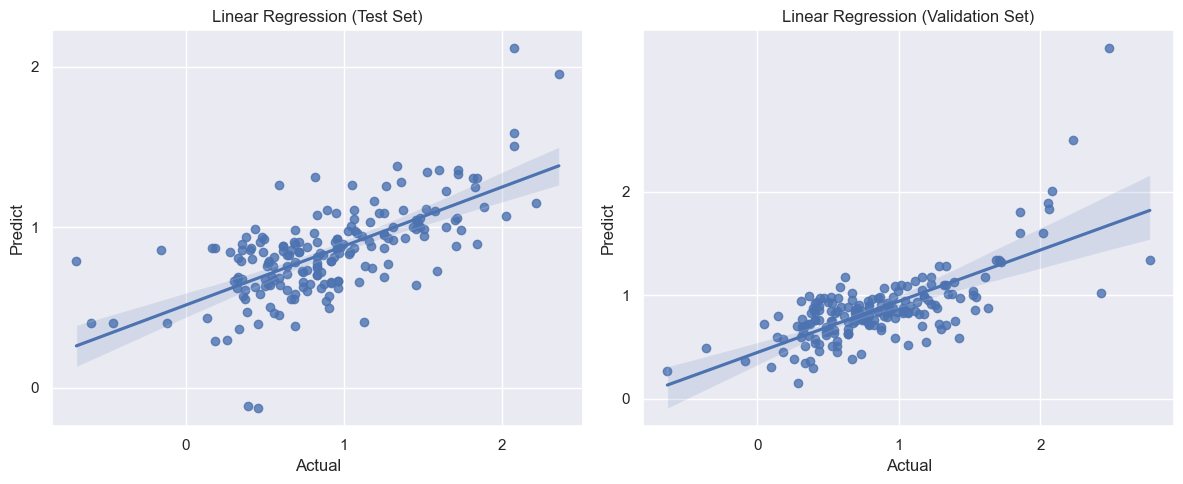

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_linear, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_linear, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()

##### Vẽ biểu đồ đường

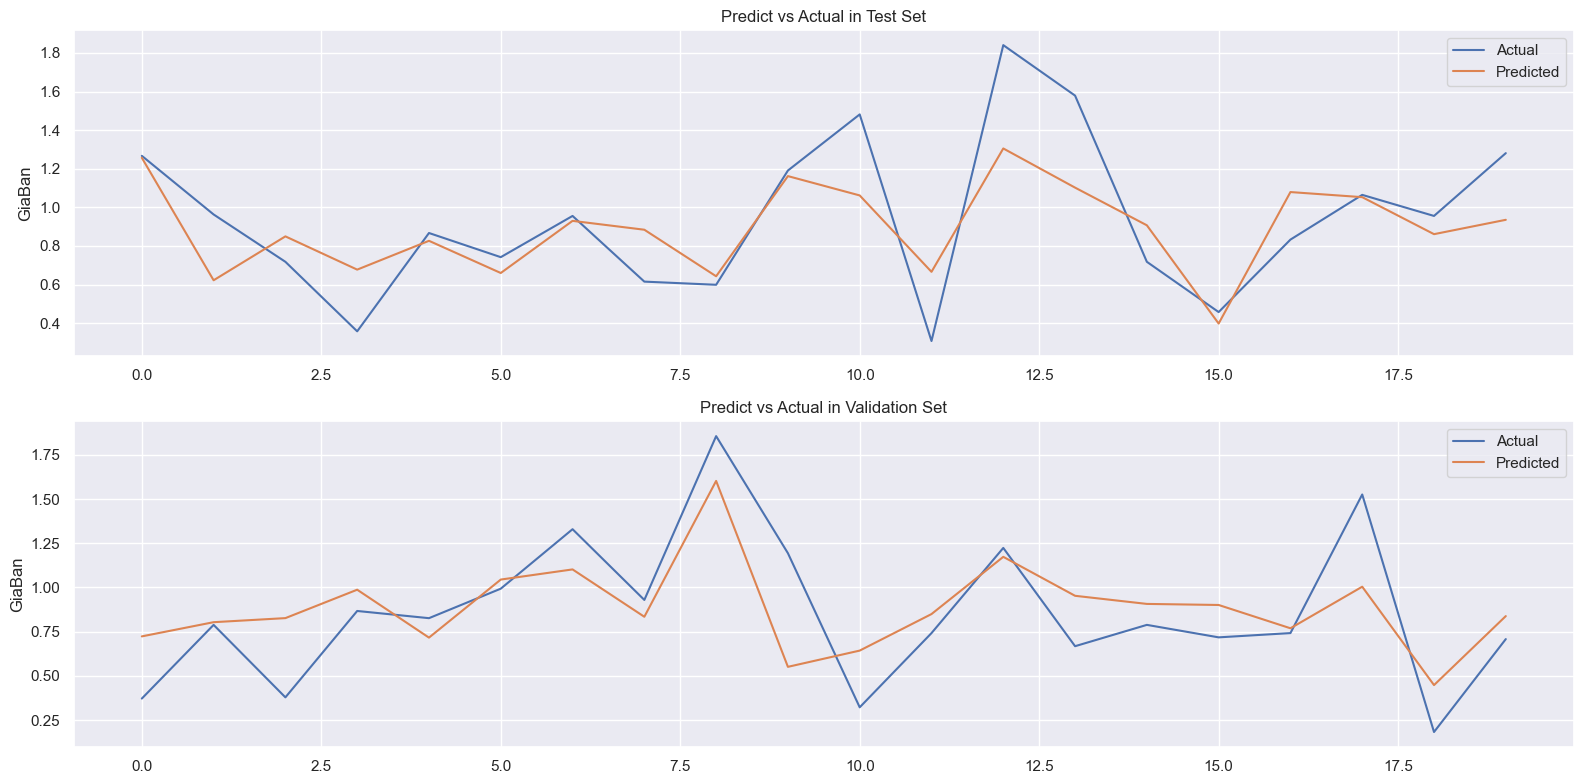

In [123]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_linear[5:25]), label='Actual')
axes[0].plot(y_test_pred[5:25], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_linear[5:25]), label='Actual')
axes[1].plot(y_val_pred[5:25], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()


#### Thống kê

In [124]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_before_linear, mae_val_before_linear, mse_val_before_linear],
        'After Optimization (Validation)': [r2_val_after_linear, mae_val_after_linear, mse_val_after_linear],
        'After Optimization (Test)': [r2_test_after_linear, mae_test_after_linear, mse_test_after_linear]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                             0.5102 │                           0.5102  │                     0.41892 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                             0.2679 │                           0.26787 │                     0.3046  │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                             0.1266 │                           0.12661 │                     0.15447 │
╘══════════╧════════════════════════════════════╧═══════════════════════

### Sử dụng mô hình RandomForestRegressor

In [125]:
X_train_randomforest=X_train_s.copy()
X_test_randomforest=X_test_s.copy()
X_val_randomforest=X_val_s.copy()
y_train_randomforest=y_train_s.copy()
y_test_randomforest=y_test_s.copy()
y_val_randomforest=y_val_s.copy()

##### Trước khi hiệu chỉnh

In [126]:
model = RandomForestRegressor(random_state = 20)
history = model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_before_random = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_before_random = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_val_before_random = mean_absolute_error(y_val_randomforest, y_val_pred).round(5)
mae_test_before_random = mean_absolute_error(y_test_randomforest, y_test_pred).round(5)
mse_val_before_random = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
mse_test_before_random = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
print("R2-score in validation: ", r2_val_before_random)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before_random))
print("Test error (MAE) in  test: {}".format(mae_test_before_random))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before_random))
print("Test error (MSE) in test: {}".format(mse_test_before_random))


R2-score in validation:  0.27854

Test error (MAE) in validation: 0.3161
Test error (MAE) in  test: 0.30679

Test error (MSE) in validation: 0.1865
Test error (MSE) in test: 0.16893


##### Tìm bộ tham số tốt nhất

In [127]:
model = RandomForestRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [None, 5, 10],  
    'min_samples_split': [2, 5, 10]  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_randomforest, y_train_randomforest)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))


Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}


#### Truyền tham số tốt nhất để chạy trên tập test

In [128]:
model = RandomForestRegressor(max_depth=5, min_samples_split = 2, n_estimators = 50, random_state=20) 
model.fit(X_train_randomforest, y_train_randomforest)
y_val_pred = model.predict(X_val_randomforest)
r2_val_after_random = r2_score(y_val_randomforest, y_val_pred).round(5)
y_test_pred = model.predict(X_test_randomforest)
r2_test_after_random = r2_score(y_test_randomforest, y_test_pred).round(5)
mae_test_after_random = mean_absolute_error(y_test_randomforest,y_test_pred).round(5)
mae_val_after_random = mean_absolute_error(y_val_randomforest,y_val_pred).round(5)
mse_test_after_random = mean_squared_error(y_test_randomforest,y_test_pred).round(5)
mse_val_after_random = mean_squared_error(y_val_randomforest,y_val_pred).round(5)
print("R2-score trên tập validation:", r2_val_after_random)
print("R2-score trên tập test:", r2_test_after_random)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after_random))
print("Test error (MAE) in test: {}".format(mae_test_after_random))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after_random))
print("Test error (MSE) in test: {}".format(mse_test_after_random))
print()


R2-score trên tập validation: 0.5119
R2-score trên tập test: 0.4228

Test error (MAE) in validation: 0.26676
Test error (MAE) in test: 0.30108

Test error (MSE) in validation: 0.12617
Test error (MSE) in test: 0.15344



##### Vẽ biểu đồ scatter

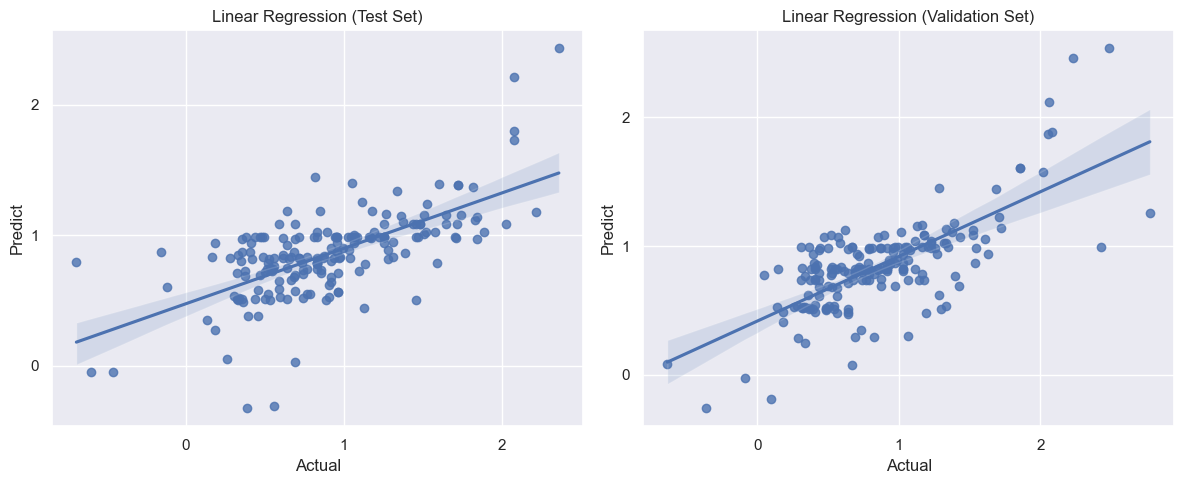

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_randomforest, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_randomforest, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()


**Nhận xét** <br/>
=> Nhìn vào đồ thị t thấy có sự tuyến tính giữa 2 biến <br/>
=> Thể hiện sự tương quan giữa 2 biến<br/>
=> Trong cùng 1 khoảng giá trị, cái actual cho thấy sự đa dạng <br/>
=> Độ phân bố đều và tập trung tại 1 chõ có độ chính xác tốt<br/>

##### Vẽ biểu đồ đường của giá dự đoán và giá thực tế

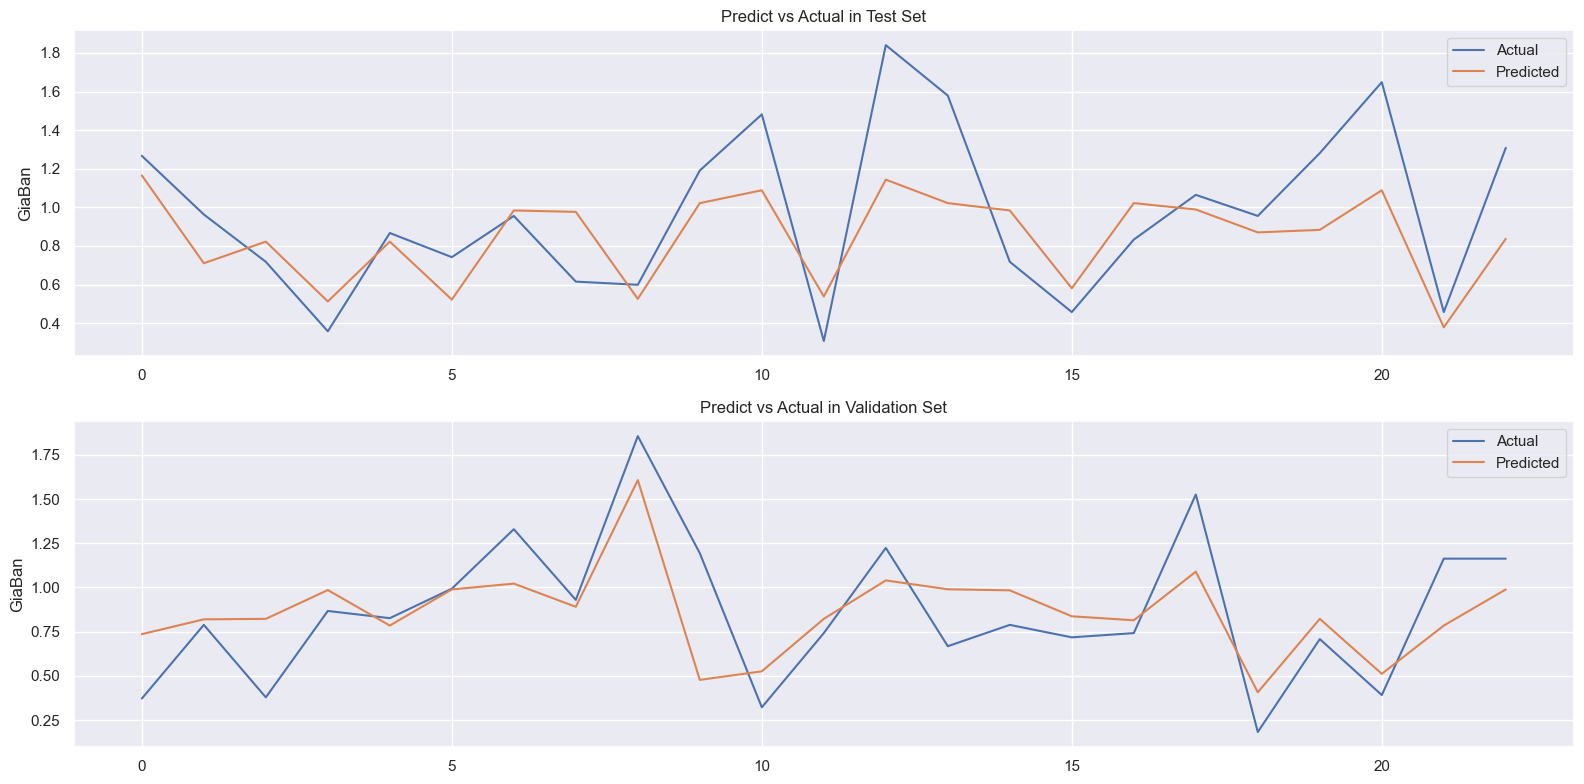

In [130]:
fig, axes = plt.subplots(2, 1, figsize=(16,8))

axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_randomforest[5:28]), label='Actual')
axes[0].plot(y_test_pred[5:28], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_randomforest[5:28]), label='Actual')
axes[1].plot(y_val_pred[5:28], label='Predicted')
axes[1].legend()

plt.tight_layout()
plt.show()


##### Thống kê

In [131]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_before_random, mae_val_before_random, mse_val_before_random],
        'After Optimization (Validation)': [r2_val_after_random, mae_val_after_random, mse_val_after_random],
        'After Optimization (Test)': [r2_test_after_random, mae_test_after_random, mse_test_after_random]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.27854 │                           0.5119  │                     0.4228  │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.3161  │                           0.26676 │                     0.30108 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                            0.1865  │                           0.12617 │                     0.15344 │
╘══════════╧════════════════════════════════════╧═══════════════════════

### Sử dụng mô hình GradientBoostingRegressor

In [132]:
X_train_boot = X_train_s.copy()
X_test_boot = X_test_s.copy()
X_val_boot = X_val_s.copy()
y_train_boot = y_train_s.copy()
y_test_boot = y_test_s.copy()
y_val_boot = y_val_s.copy()

##### Trước khi hiệu chỉnh

In [133]:
model = GradientBoostingRegressor(random_state = 20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_before_grandient = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_before_grandient = r2_score(y_test_boot, y_test_pred).round(5)
mae_val_before_grandient = mean_absolute_error(y_val_boot, y_val_pred).round(5)
mae_test_before_grandient = mean_absolute_error(y_test_boot, y_test_pred).round(5)
mse_val_before_grandient = mean_squared_error(y_val_boot,y_val_pred).round(5)
mse_test_before_grandient = mean_squared_error(y_test_boot,y_test_pred).round(5)
print("R2-score in validation: ", r2_val_before_grandient)
print()
print("Test error (MAE) in validation: {}".format(mae_val_before_grandient))
print("Test error (MAE) in  test: {}".format(mae_test_before_grandient))
print()
print("Test error (MSE) in validation: {}".format(mse_val_before_grandient))
print("Test error (MSE) in test: {}".format(mse_test_before_grandient))


R2-score in validation:  0.48381

Test error (MAE) in validation: 0.27943
Test error (MAE) in  test: 0.30091

Test error (MSE) in validation: 0.13343
Test error (MSE) in test: 0.15188


## Hiệu Chỉnh mô hình

In [134]:
model = GradientBoostingRegressor(random_state=20)
param_grid = {
    'n_estimators': [50, 100, 200, 300], 
    'learning_rate': [0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5, 6]  
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_boot, y_train_boot)
best_model = grid_search.best_estimator_
print("Best parameters: {}".format(grid_search.best_params_))

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [135]:
model = GradientBoostingRegressor(n_estimators = 50, max_depth = 4, learning_rate= 0.05,random_state=20)
model.fit(X_train_boot, y_train_boot)
y_val_pred = model.predict(X_val_boot)
r2_val_after_grandient = r2_score(y_val_boot, y_val_pred).round(5)
y_test_pred = model.predict(X_test_boot)
r2_test_after_grandient= r2_score(y_test_boot, y_test_pred).round(5)
mae_test_after_grandient = mean_absolute_error(y_test_boot,y_test_pred).round(5)
mae_val_after_grandient = mean_absolute_error(y_val_boot,y_val_pred).round(5)
mse_test_after_grandient = (mean_squared_error(y_test_boot,y_test_pred).round(5))
mse_val_after_grandient = mean_squared_error(y_val_boot,y_val_pred).round(5)

print("R2-score trên tập validation:", r2_val_after_grandient)
print("R2-score trên tập test:", r2_test_after_grandient)
print()
print("Test error (MAE) in validation: {}".format(mae_val_after_grandient))
print("Test error (MAE) in test: {}".format(mae_test_after_grandient))
print()
print("Test error (MSE) in validation: {}".format(mse_val_after_grandient))
print("Test error (MSE) in test: {}".format(mse_test_after_grandient))


R2-score trên tập validation: 0.45785
R2-score trên tập test: 0.43039

Test error (MAE) in validation: 0.28411
Test error (MAE) in test: 0.30054

Test error (MSE) in validation: 0.14015
Test error (MSE) in test: 0.15142


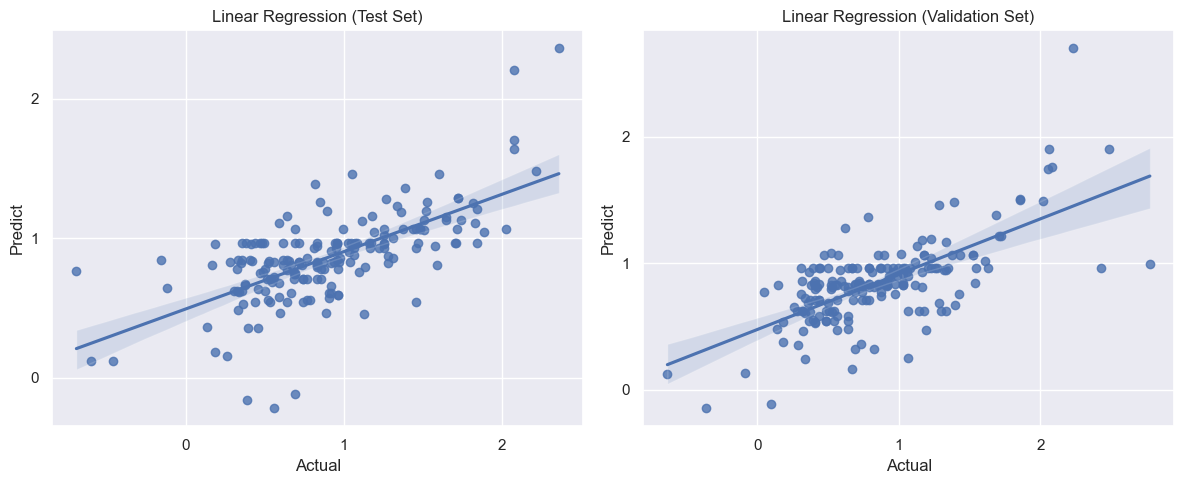

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax1 = axes[0]
sns.regplot(x=y_test_boot, y=y_test_pred, ax=ax1)
ax1.set_title('Linear Regression (Test Set)')
ax1.set_xlabel('Actual')
ax1.set_ylabel('Predict')
ax1.set_xticks(range(0, 3, 1))
ax1.set_yticks(range(0, 3, 1))
ax2 = axes[1]
sns.regplot(x=y_val_boot, y=y_val_pred, ax=ax2)
ax2.set_title('Linear Regression (Validation Set)')
ax2.set_xlabel('Actual')
ax2.set_ylabel('Predict')
ax2.set_xticks(range(0, 3, 1))
ax2.set_yticks(range(0, 3, 1))
plt.tight_layout()
plt.show()


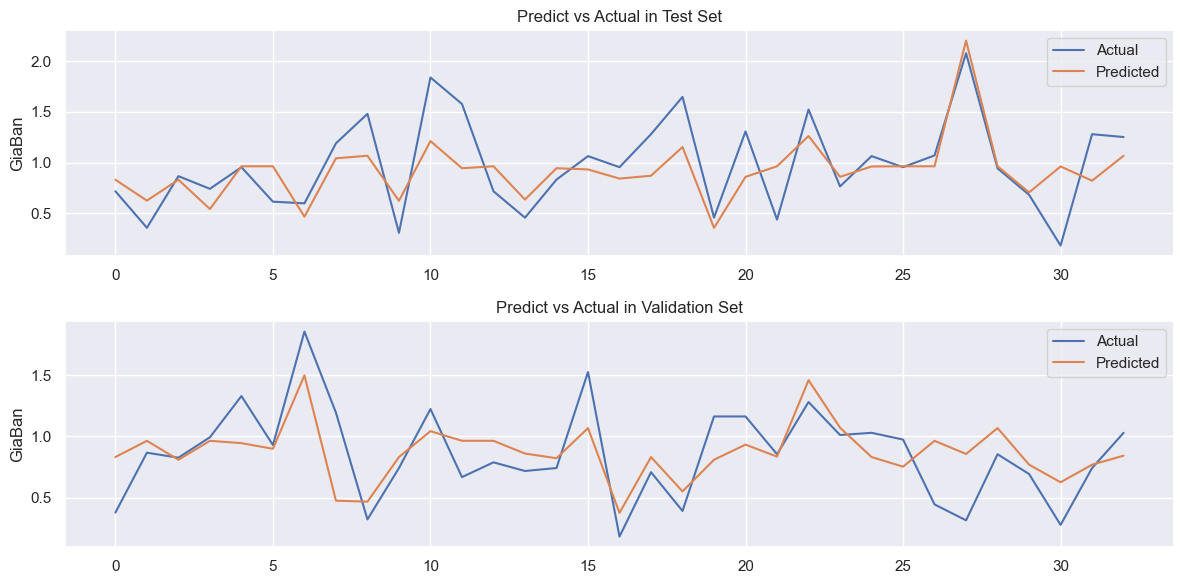

In [137]:
fig, axes = plt.subplots(2, 1, figsize=(12,6))
axes[0].set_ylabel("GiaBan")
axes[0].set_title('Predict vs Actual in Test Set')
axes[0].plot(np.array(y_test_boot[7:40]), label='Actual')
axes[0].plot(y_test_pred[7:40], label='Predicted')
axes[0].legend()
axes[1].set_ylabel("GiaBan")
axes[1].set_title('Predict vs Actual in Validation Set')
axes[1].plot(np.array(y_val_boot[7:40]), label='Actual')
axes[1].plot(y_val_pred[7:40], label='Predicted')
axes[1].legend()
plt.tight_layout()
plt.show()


In [138]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_before_grandient, mae_val_before_grandient, mse_val_before_grandient],
        'After Optimization (Validation)': [r2_val_after_grandient, mae_val_after_grandient, mse_val_after_grandient],
        'After Optimization (Test)': [r2_test_after_grandient, mae_test_after_grandient, mse_test_after_grandient]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                            0.48381 │                           0.45785 │                     0.43039 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                            0.27943 │                           0.28411 │                     0.30054 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                            0.13343 │                           0.14015 │                     0.15142 │
╘══════════╧════════════════════════════════════╧═══════════════════════

In [139]:
linear_model = LinearRegression()
randomforest_model = RandomForestRegressor( random_state=20)
gradientboost_model = GradientBoostingRegressor(random_state=20)

stacked_model = StackingRegressor(
    estimators=[('linear', linear_model), ('randomforest', randomforest_model), ('gradientboost', gradientboost_model)]
)

stacked_model.fit(X_train_s, y_train_s)
y_val_pred_stacked = stacked_model.predict(X_val_s)
r2_val_stacked_before = r2_score(y_val_s, y_val_pred_stacked)
mse_val_stacked_before = mean_squared_error(y_val_s, y_val_pred_stacked)
mae_val_stacked_before = mean_absolute_error(y_val_s, y_val_pred_stacked)

y_test_pred_stacked = stacked_model.predict(X_test_s)
r2_test_stacked_before = r2_score(y_test_s, y_test_pred_stacked)
mse_test_stacked_before = mean_squared_error(y_test_s, y_test_pred_stacked)
mae_test_stacked_before = mean_absolute_error(y_test_s, y_test_pred_stacked)

print("R2-score on validation set (Stacked Model):", r2_val_stacked_before)
print("MSE on validation set (Stacked Model):", mse_val_stacked_before)
print("MAE on validation set (Stacked Model):", mae_val_stacked_before)


R2-score on validation set (Stacked Model): 0.5099305915406298
MSE on validation set (Stacked Model): 0.12668363136422123
MAE on validation set (Stacked Model): 0.2709402780516685


In [140]:
linear_model = LinearRegression()
randomforest_model = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=200, random_state=20)
gradientboost_model = GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=20)

stacked_model = StackingRegressor(
    estimators=[('linear', linear_model), ('randomforest', randomforest_model), ('gradientboost', gradientboost_model)]
)

stacked_model.fit(X_train_s, y_train_s)
y_val_pred_stacked = stacked_model.predict(X_val_s)
r2_val_stacked_after = r2_score(y_val_s, y_val_pred_stacked)
mse_val_stacked_after = mean_squared_error(y_val_s, y_val_pred_stacked)
mae_val_stacked_after = mean_absolute_error(y_val_s, y_val_pred_stacked)

y_test_pred_stacked = stacked_model.predict(X_test_s)
r2_test_stacked_after = r2_score(y_test_s, y_test_pred_stacked)
mse_test_stacked_after = mean_squared_error(y_test_s, y_test_pred_stacked)
mae_test_stacked_after = mean_absolute_error(y_test_s, y_test_pred_stacked)

print("R2-score on validation set (Stacked Model):", r2_val_stacked_after)
print("MSE on validation set (Stacked Model):", mse_val_stacked_after)
print("MAE on validation set (Stacked Model):", mae_val_stacked_after)
print()
print("R2-score on test set (Stacked Model):", r2_test_stacked_after)
print("MSE on test set (Stacked Model):", mse_test_stacked_after)
print("MAE on test set (Stacked Model):", mae_test_stacked_after)


R2-score on validation set (Stacked Model): 0.5312777460931092
MSE on validation set (Stacked Model): 0.1211653618878567
MAE on validation set (Stacked Model): 0.26508311221530173

R2-score on test set (Stacked Model): 0.4482409702878789
MSE on test set (Stacked Model): 0.14667894282590394
MAE on test set (Stacked Model): 0.29749857488101866


In [141]:
data = {'Metric': ['R2-score', 'MAE', 'MSE'],
        'Before Optimization (Validation)': [r2_val_stacked_before, mae_val_stacked_before, mse_val_stacked_before],
        'After Optimization (Validation)': [r2_val_stacked_after, mae_val_stacked_after, mse_val_stacked_after],
        'After Optimization (Test)': [r2_test_stacked_after, mae_test_stacked_after, mse_test_stacked_after]}
print(tabulate(data, headers='keys', tablefmt='fancy_grid'))
print()

╒══════════╤════════════════════════════════════╤═══════════════════════════════════╤═════════════════════════════╕
│ Metric   │   Before Optimization (Validation) │   After Optimization (Validation) │   After Optimization (Test) │
╞══════════╪════════════════════════════════════╪═══════════════════════════════════╪═════════════════════════════╡
│ R2-score │                           0.509931 │                          0.531278 │                    0.448241 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MAE      │                           0.27094  │                          0.265083 │                    0.297499 │
├──────────┼────────────────────────────────────┼───────────────────────────────────┼─────────────────────────────┤
│ MSE      │                           0.126684 │                          0.121165 │                    0.146679 │
╘══════════╧════════════════════════════════════╧═══════════════════════

In [142]:
import pandas as pd
from tabulate import tabulate

# Create data for each model
data_gradient = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'Before Optimization (Validation)': [r2_test_before_grandient, mae_test_before_grandient, mse_test_before_grandient],
}

data_random = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'Before Optimization (Validation)': [r2_test_before_random, mae_test_before_random, mse_test_before_random],
}

data_linear = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'Before Optimization (Validation)': [r2_test_before_linear, mae_test_before_linear, mse_test_before_linear],
}

# Create DataFrames
df_gradient = pd.DataFrame(data_gradient)
df_random = pd.DataFrame(data_random)
df_linear = pd.DataFrame(data_linear)

# Merge DataFrames
df_combined = pd.concat([df_gradient, df_random['Before Optimization (Validation)'], df_linear['Before Optimization (Validation)']],
                        keys=['Gradient', 'Random', 'Linear'], axis=1)

# Print the table
print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid'))


╒════╤══════════════════════════╤════════════════════════════════════════════════════╤══════════════════════════════════════════════════╤══════════════════════════════════════════════════╕
│    │ ('Gradient', 'Metric')   │   ('Gradient', 'Before Optimization (Validation)') │   ('Random', 'Before Optimization (Validation)') │   ('Linear', 'Before Optimization (Validation)') │
╞════╪══════════════════════════╪════════════════════════════════════════════════════╪══════════════════════════════════════════════════╪══════════════════════════════════════════════════╡
│  0 │ R2-score                 │                                            0.42869 │                                          0.36453 │                                           0.4189 │
├────┼──────────────────────────┼────────────────────────────────────────────────────┼──────────────────────────────────────────────────┼──────────────────────────────────────────────────┤
│  1 │ MAE                      │                      

In [143]:
import pandas as pd
from tabulate import tabulate

# Create data for each model
data_gradient = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Validation)': [r2_val_after_grandient, mae_val_after_grandient, mse_val_after_grandient],
}

data_random = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Validation)': [r2_val_after_random, mae_val_after_random, mse_val_after_random],
}

data_linear = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Validation)': [r2_val_after_linear, mae_val_after_linear, mse_val_after_linear],
}

# Create DataFrames
df_gradient = pd.DataFrame(data_gradient)
df_random = pd.DataFrame(data_random)
df_linear = pd.DataFrame(data_linear)

# Merge DataFrames
df_combined = pd.concat([df_gradient, df_random['After Optimization (Validation)'], df_linear['After Optimization (Validation)']],
                        keys=['Gradient', 'Random', 'Linear'], axis=1)

# Print the table
print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid'))


╒════╤══════════════════════════╤═══════════════════════════════════════════════════╤═════════════════════════════════════════════════╤═════════════════════════════════════════════════╕
│    │ ('Gradient', 'Metric')   │   ('Gradient', 'After Optimization (Validation)') │   ('Random', 'After Optimization (Validation)') │   ('Linear', 'After Optimization (Validation)') │
╞════╪══════════════════════════╪═══════════════════════════════════════════════════╪═════════════════════════════════════════════════╪═════════════════════════════════════════════════╡
│  0 │ R2-score                 │                                           0.45785 │                                         0.5119  │                                         0.5102  │
├────┼──────────────────────────┼───────────────────────────────────────────────────┼─────────────────────────────────────────────────┼─────────────────────────────────────────────────┤
│  1 │ MAE                      │                                     

In [144]:
import pandas as pd
from tabulate import tabulate

# Create data for each model
data_gradient = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Test)': [r2_test_after_grandient, mae_test_after_grandient, mse_test_after_grandient],
}

data_random = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Test)': [r2_test_after_random, mae_test_after_random, mse_test_after_random],
}

data_linear = {
    'Metric': ['R2-score', 'MAE', 'MSE'],
    'After Optimization (Test)': [r2_test_after_linear, mae_test_after_linear, mse_test_after_linear],
}

# Create DataFrames
df_gradient = pd.DataFrame(data_gradient)
df_random = pd.DataFrame(data_random)
df_linear = pd.DataFrame(data_linear)

# Merge DataFrames
df_combined = pd.concat([df_gradient, df_random['After Optimization (Test)'], df_linear['After Optimization (Test)']],
                        keys=['Gradient', 'Random', 'Linear'], axis=1)

# Print the table
print(tabulate(df_combined, headers='keys', tablefmt='fancy_grid'))


╒════╤══════════════════════════╤═════════════════════════════════════════════╤═══════════════════════════════════════════╤═══════════════════════════════════════════╕
│    │ ('Gradient', 'Metric')   │   ('Gradient', 'After Optimization (Test)') │   ('Random', 'After Optimization (Test)') │   ('Linear', 'After Optimization (Test)') │
╞════╪══════════════════════════╪═════════════════════════════════════════════╪═══════════════════════════════════════════╪═══════════════════════════════════════════╡
│  0 │ R2-score                 │                                     0.43039 │                                   0.4228  │                                   0.41892 │
├────┼──────────────────────────┼─────────────────────────────────────────────┼───────────────────────────────────────────┼───────────────────────────────────────────┤
│  1 │ MAE                      │                                     0.30054 │                                   0.30108 │                                   0.